In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
import cv2 as cv
import json

In [2]:
def create_df():
    name = []
    filenames = os.listdir("dataset/images")
    filenames = sorted(filenames, key=lambda x : int(x.split('.')[0]))
    for filename in filenames:
        name.append(filename.split('.')[0])
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [3]:
def percentage_pattern(mask, class_labels):
    total_pixels = mask.size
    percentages = [(mask == label).sum() / total_pixels * 100 for label in class_labels]
    return percentages

**Here I create a dataframe containing features that can be used for clustering**

In [4]:
# Create dataframe
df = create_df()

mask_data = []
mask_dir = "dataset/masks/"

# Create dataframe with features
for i in range(len(df)):
    id = df['id'][i] # bepaal de naam van de afbeelding, bij ons is dat het zelfde als de index
    mask = mask_dir + id + ".png"
    # Load mask
    mask = cv.imread(mask, cv.IMREAD_GRAYSCALE)
    
    class_labels = np.unique(mask)[1:] # Skip background
    num_classes = len(class_labels)
    pp = percentage_pattern(mask, class_labels)
    resolution = mask.shape
    
    mask_data.append({
        "id": id,
        "num_classes": num_classes,
        "class_labels": class_labels,
        "percentage_pattern": pp,
        "resolution": resolution,
    })

features_df = pd.DataFrame(mask_data)

In [5]:
df.head(5)

,id
0,0
1,1
2,2
3,3
4,4


In [6]:
features_df.head(5)

,id,num_classes,class_labels,percentage_pattern,resolution
0,0,2,"[2, 29]","[11.186636133104805, 6.54596203139977]","(1364, 5559)"
1,1,3,"[11, 27, 29]","[0.8281089368435395, 9.722907648075207, 4.0153...","(3712, 5568)"
2,2,3,"[1, 12, 15]","[3.965253070191736, 17.81267611412505, 2.82848...","(3712, 5568)"
3,3,3,"[3, 4, 6]","[1.1695925323438843, 6.388954250677345, 2.5294...","(1064, 5528)"
4,4,1,[16],[12.562076625111912],"(1323, 5421)"


In [ ]:
# Class labels list
with open("obj_class_to_machine_color.json", "r") as f:
    class_labels = json.load(f)

# create a list of the keys
class_labels = list(class_labels.keys())

class_frequencies = np.zeros(36)

# Determine how frequent each class appears..
for cls in range(1, 37):
    for j in range(len(features_df)):
        if cls in features_df["class_labels"][j]:
            class_frequencies[cls-1] += 1

for i in range(len(class_labels)):
    # print(f"Class: {class_labels[i]} appears: {class_frequencies[i]} times")
    # create a dict of this
    class_frequencies_dict = dict(zip(class_labels, class_frequencies))

# print(class_frequencies_dict)

# pandas dataframe
df_class_freq = pd.DataFrame(class_frequencies_dict.items(), columns=["class", "frequency"])

# sort the dataframe based on frequency
df_class_freq = df_class_freq.sort_values(by="frequency", ascending=False)

df_class_freq

,class,frequency
5,Ionic kyma decoration,325.0
14,Bead-and-reel (double double),239.0
0,Lesbian kyma decoration,160.0
1,Anthemion (large & capital & pulvinus),121.0
29,Anthemion (small & soffit & top moulding archi...,106.0
28,Acanthus leaves (solo) (capital & frieze & mod...,82.0
11,Scroll pattern (large),73.0
10,Ignore,63.0
6,Leaf band decoration,41.0
13,Scroll pattern (soffit),38.0


# One hot encoding clustering

In [9]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# One-hot encode class labels
mlb = MultiLabelBinarizer()
class_labels_one_hot = mlb.fit_transform(features_df['class_labels'])

# print(class_labels_one_hot)

# Affinity propagation clustering on classes
affinity_model = AffinityPropagation(damping=0.8, preference=-50, random_state=42)
affinity_model.fit(class_labels_one_hot)

# Add cluster labels to the dataframe
df['cluster_label'] = affinity_model.labels_

n_clusters = len(affinity_model.cluster_centers_indices_)
print(f"Number of clusters: {n_clusters}")

Number of clusters: 22


In [10]:
df['cluster_label'].value_counts()

cluster_label
4     71
11    68
0     66
1     63
16    62
17    38
6     33
8     18
9     15
5     13
2      8
13     6
10     6
7      5
21     4
3      3
19     3
12     3
14     2
15     2
20     2
18     1
Name: count, dtype: int64

**We can use dataframe with cluster labels now for making a split.**

In [11]:
from sklearn.model_selection import train_test_split

# Create train and test sets
# To Do

# Clustering based on least frequent class

In [8]:
features_df.head(10)

,id,num_classes,class_labels,percentage_pattern,resolution
0,0,2,"[2, 29]","[11.186636133104805, 6.54596203139977]","(1364, 5559)"
1,1,3,"[11, 27, 29]","[0.8281089368435395, 9.722907648075207, 4.0153...","(3712, 5568)"
2,2,3,"[1, 12, 15]","[3.965253070191736, 17.81267611412505, 2.82848...","(3712, 5568)"
3,3,3,"[3, 4, 6]","[1.1695925323438843, 6.388954250677345, 2.5294...","(1064, 5528)"
4,4,1,[16],[12.562076625111912],"(1323, 5421)"
5,5,3,"[2, 11, 29]","[18.023746957676874, 7.109775611251486, 4.9492...","(3712, 5568)"
6,6,4,"[1, 2, 6, 15]","[2.8833948060776193, 10.25248723339082, 3.7784...","(2147, 5550)"
7,7,2,"[15, 29]","[2.4378065546967895, 27.44365122126437]","(3712, 5568)"
8,8,4,"[6, 11, 15, 30]","[6.667811408479489, 2.0787417865016846, 5.1364...","(3712, 5568)"
9,9,4,"[1, 10, 12, 15]","[8.609085743921439, 6.867870221427654, 31.2666...","(1364, 5564)"


In [9]:
def get_lowest_frequency_label(labels, class_label_mapping):
    # returns the class label with the lowest frequency, and the absolute frequency of this label
    values = [class_label_mapping[x] for x in labels]
    return labels[values.index(min(values))], min(values)

In [10]:
# Explode the class_labels column, then determine the frequency of each class label
class_label_counts = features_df['class_labels'].explode().value_counts()

class_label_mapping = class_label_counts.to_dict()

# print(class_label_mapping)
# print(class_label_mapping[29]) # class label --> count
get_lowest_frequency_label([2, 29], class_label_mapping)

(29, 82)

In [11]:
# Add column with class label frequencies to features_df
# [2,7,9] -> ['freq1', 'freq2', 'freq3'] (apply = voor hele kolom, x is de lijst van class labels in een rij)
features_df["class_labels"].apply((lambda x: [class_label_mapping[label] for label in x])) 

# Only keep class label with the lowest frequency
features_df['least_freq_label'] = features_df['class_labels'].apply(lambda x: get_lowest_frequency_label(x, class_label_mapping)[0])

features_df['class_label_freq'] = features_df['class_labels'].apply(lambda x: get_lowest_frequency_label(x, class_label_mapping)[1])

In [12]:
features_df.head(10)

,id,num_classes,class_labels,percentage_pattern,resolution,least_freq_label,class_label_freq
0,0,2,"[2, 29]","[11.186636133104805, 6.54596203139977]","(1364, 5559)",29,82
1,1,3,"[11, 27, 29]","[0.8281089368435395, 9.722907648075207, 4.0153...","(3712, 5568)",27,35
2,2,3,"[1, 12, 15]","[3.965253070191736, 17.81267611412505, 2.82848...","(3712, 5568)",12,73
3,3,3,"[3, 4, 6]","[1.1695925323438843, 6.388954250677345, 2.5294...","(1064, 5528)",4,32
4,4,1,[16],[12.562076625111912],"(1323, 5421)",16,16
5,5,3,"[2, 11, 29]","[18.023746957676874, 7.109775611251486, 4.9492...","(3712, 5568)",11,63
6,6,4,"[1, 2, 6, 15]","[2.8833948060776193, 10.25248723339082, 3.7784...","(2147, 5550)",2,121
7,7,2,"[15, 29]","[2.4378065546967895, 27.44365122126437]","(3712, 5568)",29,82
8,8,4,"[6, 11, 15, 30]","[6.667811408479489, 2.0787417865016846, 5.1364...","(3712, 5568)",11,63
9,9,4,"[1, 10, 12, 15]","[8.609085743921439, 6.867870221427654, 31.2666...","(1364, 5564)",10,25


In [16]:
# Some queries...
# print(features_df['class_label_freq'].value_counts())
# features_df[features_df['class_label_freq'] < 5]
features_df[features_df['class_label_freq'] < 5].count()

id                    25
num_classes           25
class_labels          25
percentage_pattern    25
resolution            25
least_freq_label      25
class_label_freq      25
dtype: int64

In [17]:
# Normalize features
normalized_features = StandardScaler().fit_transform(features_df[["class_label_freq"]])
print(normalized_features.shape)

# Apply Affinity Propagation
affinity_model = AffinityPropagation(damping=0.8, preference=-20, random_state=42)
affinity_model.fit(normalized_features)

n_clusters = len(affinity_model.cluster_centers_indices_)
print(f"Number of clusters: {n_clusters}")

# Add cluster labels to the dataframe
features_df['cluster_label'] = affinity_model.labels_


(492, 1)
Number of clusters: 4


In [19]:
features_df['cluster_label'].value_counts()

cluster_label
2    275
3    100
0     89
1     28
Name: count, dtype: int64

In [21]:
data_split_df = features_df.copy()

# Remove rows with class label frequency of less then 5
data_split_df = data_split_df[data_split_df['class_label_freq'] > 5]

data_split_df['cluster_label'].value_counts()

cluster_label
2    240
3    100
0     89
1     28
Name: count, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

cluster_labels = data_split_df['cluster_label'].values

# Code for train and test split
train_clusters, test_clusters = train_test_split(
    data_split_df['id'].values, 
    test_size=0.1, 
    random_state=42, 
    stratify=cluster_labels
)

train_cluster_labels = data_split_df[data_split_df['id'].isin(train_clusters)]['cluster_label'].values

train_clusters, val_clusters = train_test_split(
    train_clusters, 
    test_size=0.15, 
    random_state=42, 
    stratify=train_cluster_labels
)

# Create train, validation, and test DataFrames
train_df = features_df[features_df['id'].isin(train_clusters)]
val_df = features_df[features_df['id'].isin(val_clusters)]
test_df = features_df[features_df['id'].isin(test_clusters)]

# Print sizes of the splits
print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")


# Save the splits to disk
train_df.to_csv("data_splits/least_freq_label/train.csv", index=False)
val_df.to_csv("data_splits/least_freq_label/val.csv", index=False)
test_df.to_csv("data_splits/least_freq_label/test.csv", index=False)

Train set: (349, 8)
Validation set: (62, 8)
Test set: (46, 8)


# Just clustered on features  

In [23]:
# Prepare features
features_df['image_size'] = features_df['resolution'].apply(lambda x: x[0] * x[1])  # Flatten resolution to area

features_df['total_pp'] = features_df['percentage_pattern'].apply(lambda x: sum(x))

features_df.head(10)

,id,num_classes,class_labels,percentage_pattern,resolution,least_freq_label,class_label_freq,cluster_label,image_size,total_pp
0,0,2,"[2, 29]","[11.186636133104805, 6.54596203139977]","(1364, 5559)",29,82,0,7582476,17.732598
1,1,3,"[11, 27, 29]","[0.8281089368435395, 9.722907648075207, 4.0153...","(3712, 5568)",27,35,2,20668416,14.566380
2,2,3,"[1, 12, 15]","[3.965253070191736, 17.81267611412505, 2.82848...","(3712, 5568)",12,73,0,20668416,24.606414
3,3,3,"[3, 4, 6]","[1.1695925323438843, 6.388954250677345, 2.5294...","(1064, 5528)",4,32,2,5881792,10.088031
4,4,1,[16],[12.562076625111912],"(1323, 5421)",16,16,2,7171983,12.562077
5,5,3,"[2, 11, 29]","[18.023746957676874, 7.109775611251486, 4.9492...","(3712, 5568)",11,63,0,20668416,30.082784
6,6,4,"[1, 2, 6, 15]","[2.8833948060776193, 10.25248723339082, 3.7784...","(2147, 5550)",2,121,3,11915850,19.443548
7,7,2,"[15, 29]","[2.4378065546967895, 27.44365122126437]","(3712, 5568)",29,82,0,20668416,29.881458
8,8,4,"[6, 11, 15, 30]","[6.667811408479489, 2.0787417865016846, 5.1364...","(3712, 5568)",11,63,0,20668416,21.894344
9,9,4,"[1, 10, 12, 15]","[8.609085743921439, 6.867870221427654, 31.2666...","(1364, 5564)",10,25,2,7589296,51.951103


In [24]:
# Normalize features
normalized_features = StandardScaler().fit_transform(features_df[["num_classes", "class_label_freq", "image_size", "total_pp"]])
print(normalized_features.shape)

# Apply Affinity Propagation
affinity_model = AffinityPropagation(damping=0.7, preference=-80, random_state=42)
affinity_model.fit(normalized_features)

(492, 4)


AffinityPropagation(damping=0.7, preference=-80, random_state=42)

In [26]:
n_clusters = len(affinity_model.cluster_centers_indices_)
print(f"Number of clusters: {n_clusters}")

features_df["cluster_label"] = affinity_model.labels_

Number of clusters: 6


In [27]:
# Print the number of images in each cluster
print(features_df["cluster_label"].value_counts().sort_index())

cluster_label
0     65
1     82
2     72
3     82
4     37
5    154
Name: count, dtype: int64


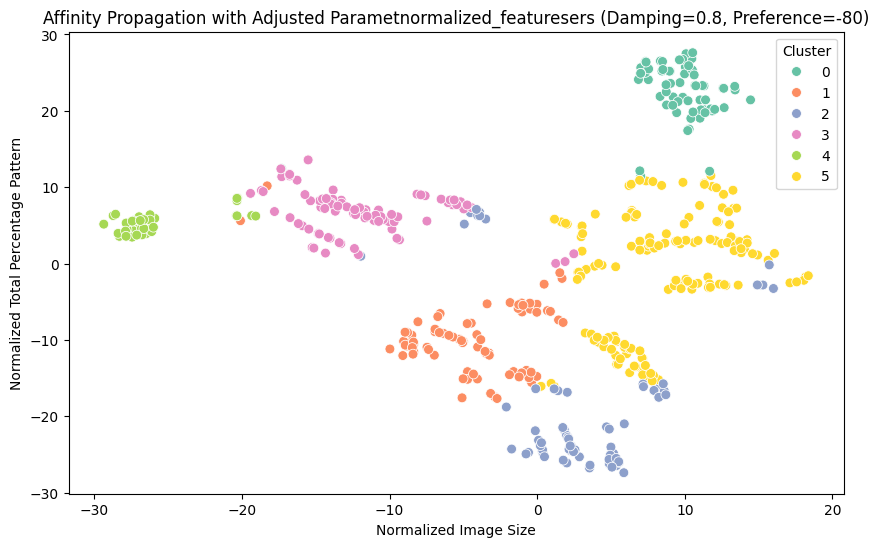

In [28]:
# 2D visualization when using 2 features
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

# TSNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(normalized_features)

# Visualize the clusters again
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1], hue=affinity_model.labels_, palette='Set2', s=50)
plt.title('Affinity Propagation with Adjusted Parametnormalized_featuresers (Damping=0.8, Preference=-80)')
plt.xlabel('Normalized Image Size')
plt.ylabel('Normalized Total Percentage Pattern')
plt.legend(title='Cluster', loc='best')
plt.show()